In [1]:
import time, joblib, os
import numpy as np
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error
from utils.dataset import load_dataset

In [2]:
data_root_path = 'data'+os.sep
data_paths = os.listdir('data')
start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [3]:
train_dataset_indices = [24, 23, 18, 20, 19, 17, 22, 21, 3, 5, 4, 1, 6, 7, 8, 2, 26, 29, 25, 27, 32, 28, 30, 31]
val_dataset_indices = [16, 13, 15, 9, 14, 10, 12, 11]

train_feature_dataset, train_target_dataset, val_feature_dataset, val_target_dataset = load_dataset(train_dataset_indices=np.array(train_dataset_indices),
                                                                                                    val_dataset_indices=np.array(val_dataset_indices))  # create feature data
print('train feature data length: ', train_feature_dataset.shape[0], ',', 'types of data: ', train_feature_dataset.shape[1])
print('validation feature data length: ', val_feature_dataset.shape[0], ',', 'types of data: ', val_feature_dataset.shape[1])

train feature data length:  25454 , types of data:  4
validation feature data length:  7813 , types of data:  4


In [8]:
objective = 'regression'
depth = 15
leaves = 2**depth
lr = 0.001
n_estimators = 10000
boosting_type = 'gbdt'
max_bin = 255
n_leaf = 31

depth_list = list(range(1, 15, 1))
leaves_list = list(range(2, 100, 1))

In [9]:
est_flow_model = lgb.LGBMRegressor(objective=objective, n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=100,
                                   force_col_wise=True, verbose=1)

est_flow_model.fit(X=train_feature_dataset, y=train_target_dataset, eval_set=(val_feature_dataset, val_target_dataset), eval_metric='L2', 
                   callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Info] Total Bins 1001
[LightGBM] [Info] Number of data points in the train set: 25454, number of used features: 4
[LightGBM] [Info] Start training from score 469.103083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5791]	valid_0's l2: 4125.41


LGBMRegressor(force_col_wise=True, learning_rate=0.001, n_estimators=10000,
              num_leaves=100, objective='regression', verbose=1)

The mae of prediction is: 33.6

result data is saved!
model is saved!


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

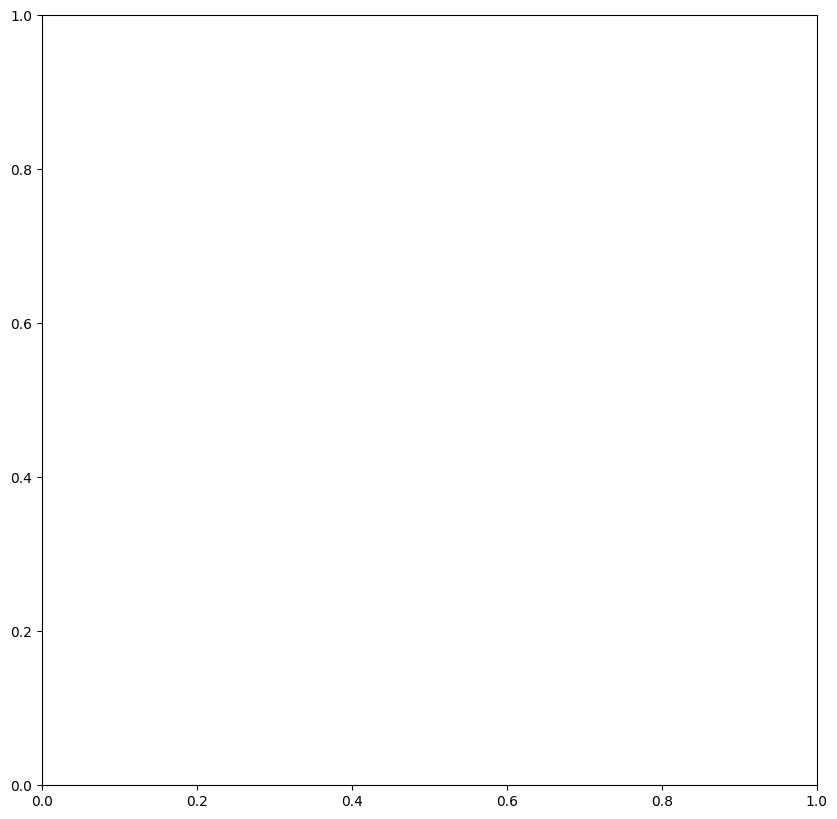

In [10]:
pred_output = est_flow_model.predict(val_feature_dataset, num_iteration=est_flow_model._best_iteration)
print('The mae of prediction is:', f'{mean_absolute_error(val_target_dataset, pred_output):.1f}', end='\n\n')

pred_result = np.vstack((val_target_dataset, pred_output)).T
np.savetxt('result' + os.sep + 'result.csv', pred_result, delimiter=",")
print('result data is saved!', end='\n\n')

# save model
joblib.dump(est_flow_model, 'saved_model' + os.sep + 'model' + '.pkl')
print('model is saved!')

lgb.plot_tree(est_flow_model, figsize=(10,10))
lgb.create_tree_digraph(est_flow_model).render('display_graph' + os.sep + 'model' + '.gv', format='jpg', view=False)
